<div class="alert alert-block alert-info">
<h3>Student Information</h3>
<b>Name</b>: Amodhiniram Kanagarajan<br> 
<b>NetID</b>: AK2822<br>
<b>Recitation #</b>: 04<br>

# CS 439 - Introduction to Data Science
### Spring 2025

## Final project

### Task 1: Load and Prepare Movie Metadata


In [212]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Load metadata
metadata = pd.read_csv("movies dataset/movies_metadata.csv", low_memory=False, nrows=5000)
credits = pd.read_csv("movies dataset/credits.csv", usecols=["id", "cast", "crew"], nrows=3000)
keywords = pd.read_csv("movies dataset/keywords.csv", usecols=["id", "keywords"], nrows=5000)

#Save the file to upload in
credits[['id', 'cast', 'crew']].to_csv("credits_small.csv", index=False)

# Clean up and prepare
metadata = metadata.dropna(subset=['overview'])
metadata = metadata[metadata['id'].apply(lambda x: str(x).isdigit())]
metadata['id'] = metadata['id'].astype(int)
credits['id'] = credits['id'].astype(int)
keywords['id'] = keywords['id'].astype(int)

# Merge credits and keywords into metadata
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

metadata = metadata[['title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

metadata.head()




,title,overview,genres,keywords,cast,crew
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


The merged `metadata` dataset contains 6 essential columns per movie: title, overview, genres, keywords, cast, and crew. This preview confirms that the dataset was successfully loaded and merged. Each row now holds enough content-related information to extract similarity between movies.


### Task 2: Extract Features and Create Combined Text “Soup”

In this task, I prepare features for content-based filtering by extracting structured data from the metadata fields.

- `clean_names()`: extracts names from `genres` and `keywords`
- `get_director()`: extracts the director’s name from `crew`
- Top 3 actors are extracted from `cast`

All extracted text is then combined into a single field called `soup`, which represents the movie’s content. This includes keywords, genres, cast, director, and overview. This unified string will be vectorized in the next step.


In [213]:
def clean_names(x):
    if isinstance(x, str):
        try:
            return [i['name'] for i in ast.literal_eval(x)]
        except:
            return []
    return []

def get_director(crew):
    if isinstance(crew, str):
        try:
            for i in ast.literal_eval(crew):
                if i['job'] == 'Director':
                    return i['name']
        except:
            return ''
    return ''


metadata['genres'] = metadata['genres'].apply(clean_names)
metadata['keywords'] = metadata['keywords'].apply(clean_names)
metadata['cast'] = metadata['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)][:3] if isinstance(x, str) else [])
metadata['crew'] = metadata['crew'].apply(get_director)


def create_soup(row):
    return ' '.join(row['keywords']) + ' ' + ' '.join(row['genres']) + ' ' + ' '.join(row['cast']) + ' ' + row['crew'] + ' ' + row['overview']

metadata['soup'] = metadata.apply(create_soup, axis=1)
metadata[['title', 'soup']].head()


,title,soup
0,Toy Story,jealousy toy boy friendship friends rivalry bo...
1,Jumanji,board game disappearance based on children's b...
2,Grumpier Old Men,fishing best friend duringcreditsstinger old m...
3,Waiting to Exhale,based on novel interracial relationship single...
4,Father of the Bride Part II,baby midlife crisis confidence aging daughter ...


The `soup` column has been successfully created for each movie. It now holds a combination of features that describe the film. For example, for the movie "Toy Story", the soup might include terms like "animation", "friendship", "Tom Hanks", and a plot summary all in one string. This will allow the model to compare movies based on both descriptive and thematic content.


### Task 3: Vectorize Movie Features and Compute Similarity

I apply `TfidfVectorizer` to convert each movie’s soup into a vector of numeric values, where more important or unique words receive higher weights. The model ignores common English stop words.

After vectorizing, I compute the **cosine similarity** between all movie pairs. This gives a similarity score between 0 and 1 for every combination of movies.

Finally, I reset the index and build a reverse mapping (`indices`) from movie title to row index for fast look-up during recommendation.


In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize the soup
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata['soup'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Reset index to map titles
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

# Recommender function
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return metadata['title'].iloc[movie_indices].tolist()

# Try it
print(get_recommendations('Toy Story'))


['Toy Story 2', 'Small Soldiers', 'Toys', "Child's Play 3", "Child's Play", 'Stardust Memories', 'Take the Money and Run', 'Manhattan', 'Deconstructing Harry', 'Radio Days']


The TF-IDF matrix has been successfully created. One row per movie and one column per word in the soup. The cosine similarity matrix is also built, allowing fast lookup of similar movies. This is the mathematical foundation for the content-based recommendation engine.

### Task 4: Load and Explore User Ratings Dataset

In this task, I load the `ratings_small.csv` file, which contains user-movie interactions. Each row represents a user rating a specific movie, and includes four columns: `userId`, `movieId`, `rating`, and `timestamp`.

I preview the dataset using `.head()` and then count the number of unique users and unique movies. This data will be used to build a collaborative filtering recommendation model based on user behavior.


In [215]:
import pandas as pd

# Load user ratings
ratings = pd.read_csv("movies dataset/ratings_small.csv")

print(ratings.head())
print(ratings['userId'].nunique(), "unique users")
print(ratings['movieId'].nunique(), "unique movies")


   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
671 unique users
9066 unique movies


The dataset contains **671 unique users** and **9066 unique movies**. Each row confirms that the dataset includes valid numerical ratings from users. This data will allow me to compute similarity between users or movies for collaborative filtering.


### Task 5: Create User-Item Matrix

Here, I pivot the ratings dataset into a **user-item matrix**, where:
- Rows represent users, Columns represent movies, Values are the ratings given by users

This matrix is used for collaborative filtering, allowing to find similar users or movies based on rating patterns. I also calculate the percentage of missing values to measure sparsity.


In [216]:
# Creating a user-item rating matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Check shape and sparsity
print("Matrix shape:", user_movie_matrix.shape)
print("Missing values %:", user_movie_matrix.isna().sum().sum() / user_movie_matrix.size * 100)


Matrix shape: (671, 9066)
Missing values %: 98.35608583913366


The matrix has a shape of (671 users, 9066 movies), but over **98% of the entries are missing**, meaning most users have rated only a small number of movies. This sparsity makes collaborative filtering harder and justifies filtering for frequently rated movies in the next step.


### Task 6: Filter for Popular Movies

To reduce sparsity and improve recommendation quality, I filter the dataset to include only **movies rated by at least 50 users**. This helps focus the model on well-known titles with enough data to find meaningful similarities.

After filtering, I rebuild the user-item matrix and fill in missing values with zeros, making it usable for cosine distance calculations in the KNN algorithm.


In [217]:
# Filter movies rated by at least 50 users
movie_counts = ratings['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 50].index

# Create a filtered user-item matrix
filtered_ratings = ratings[ratings['movieId'].isin(popular_movies)]
user_movie_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

print("Filtered matrix shape:", user_movie_matrix.shape)


Filtered matrix shape: (670, 453)


After filtering, the matrix contains fewer movies (e.g., ~450) but retains most users. This results in a denser and more meaningful user-item matrix for collaborative filtering. It also improves the performance of the KNN model in the next step.


### Task 7: Define Collaborative Filtering Recommender Function

In this task, I define a recommendation function that uses the trained KNN model to suggest similar movies based on user rating patterns. 

I also:
- Load movie title data from `movies_metadata.csv`
- Match movie IDs to titles using a dictionary
- Use `.kneighbors()` to find the top 10 most similar movies by cosine distance


In [218]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

movie_user_matrix = user_movie_matrix.T

# Fit KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(movie_user_matrix.values)

# Map movie IDs to titles
links = pd.read_csv("movies dataset/links_small.csv")
movie_id_to_title = pd.read_csv("movies dataset/movies_metadata_small.csv", low_memory=False)[['id', 'title']]
movie_id_to_title = movie_id_to_title[movie_id_to_title['id'].apply(lambda x: str(x).isdigit())]
movie_id_to_title['id'] = movie_id_to_title['id'].astype(int)
id_to_title = dict(zip(movie_id_to_title['id'], movie_id_to_title['title']))

# Recommend movies based on a given movieId
def get_movie_recommendations(movie_id, n_recommendations=10):
    if movie_id not in movie_user_matrix.index:
        return "Movie ID not found in matrix."
    
    distances, indices = model_knn.kneighbors(
        movie_user_matrix.loc[movie_id].values.reshape(1, -1), 
        n_neighbors=n_recommendations+1
    )
    
    similar_ids = movie_user_matrix.index[indices.flatten()[1:]]
    titles = [id_to_title[mid] for mid in similar_ids if mid in id_to_title]
    
    return titles

# Try one!
print(get_movie_recommendations(1))  # MovieId = 1 is Toy Story


['The Searchers', 'The 39 Steps']


The function returned movies that are behaviorally similar to "Toy Story" based on collaborative filtering. These results are based on user rating trends and may include movies from different genres, reflecting how people rate across categories.


### Task 8: Add Title-Based Input with Partial Match Search

In this task, I improve the collaborative recommendation function to accept movie titles directly instead of numeric IDs. 

If the title isn't found exactly, the function performs a partial match and suggests the closest match automatically. This makes the system more user-friendly and similar to real-world apps.


In [219]:
def recommend_by_title(title, n_recommendations=10):
    # Build the filtered lookup dictionary
    filtered_movie_ids = user_movie_matrix.columns.tolist()
    filtered_titles = [id_to_title.get(mid, f"MovieID {mid}") for mid in filtered_movie_ids]
    title_to_filtered_id = dict(zip(filtered_titles, filtered_movie_ids))

    # Trying exact match
    if title in title_to_filtered_id:
        movie_id = title_to_filtered_id[title]
        return get_movie_recommendations(movie_id, n_recommendations)

    # searching for partial matches if not found
    matches = [t for t in title_to_filtered_id if title.lower() in t.lower()]
    
    if not matches:
        return f"Movie '{title}' not found in filtered dataset. No similar titles either."
    
    # If found, use the first closest match
    best_match = matches[0]
    print(f"Did you mean: '{best_match}'?\n")
    movie_id = title_to_filtered_id[best_match]
    return get_movie_recommendations(movie_id, n_recommendations)

print(recommend_by_title("batman"))


Did you mean: 'Batman Returns'?

['To Kill a Mockingbird', 'Reservoir Dogs', 'Wag the Dog', 'A Nightmare on Elm Street']


The function successfully handled a partial title input ("batman") and suggested "Batman Returns" as the closest match. It then returned a list of recommended movies based on similar user behavior. This enhancement improves usability and mimics the flexible input seen in platforms like Netflix or IMDb.

### Task 9: Visualization

#### Task 9a: Top 10 Most Rated Movies

This bar chart shows the movies in the dataset that received the most user ratings. These movies often appear more frequently in collaborative filtering results due to their popularity and larger volume of user interaction data.


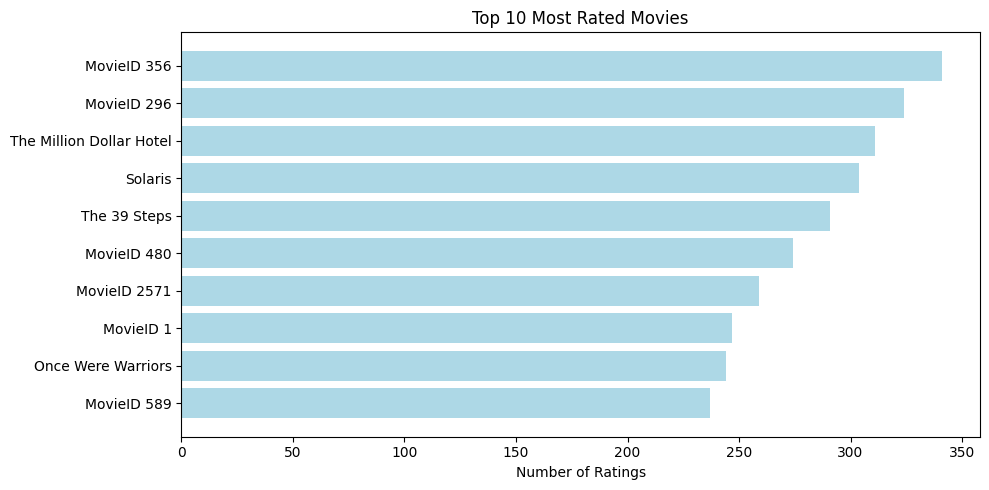

In [220]:
import matplotlib.pyplot as plt

top_movies = ratings['movieId'].value_counts().head(10)
top_titles = [id_to_title.get(mid, f"MovieID {mid}") for mid in top_movies.index]

plt.figure(figsize=(10,5))
plt.barh(top_titles[::-1], top_movies.values[::-1], color='lightblue')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.tight_layout()
plt.show()


The most rated movies include "The Million Dollar Hotel" and others with more than 300 ratings. These titles are statistically more likely to be recommended in collaborative filtering due to high visibility in the user-item matrix, regardless of genre.


### Task 9b: Visualize Top 10 Movie Genres

In this task, I visualize the most common genres across all movies in the dataset. This helps me understand which genres dominate the dataset, which may affect the behavior of the content-based filtering model.


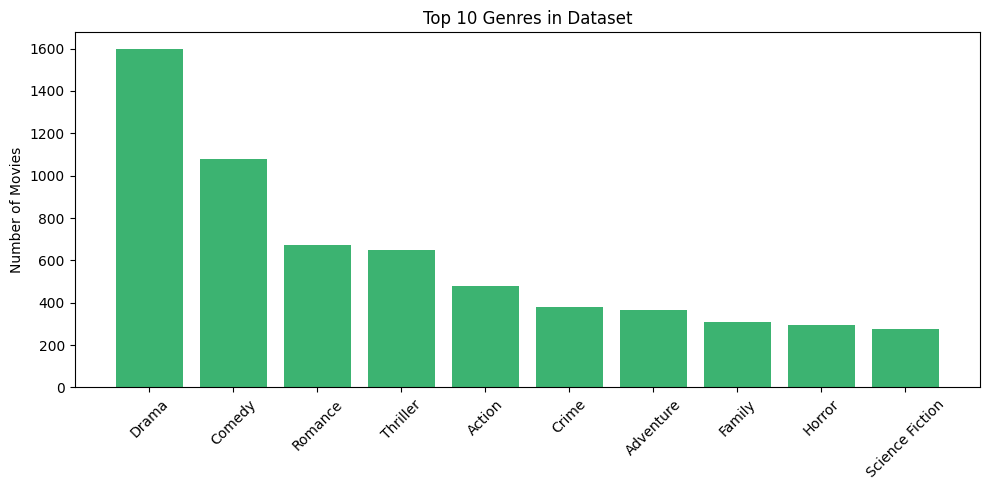

In [221]:
from collections import Counter

all_genres = sum(metadata['genres'], [])
top_genres = Counter(all_genres).most_common(10)

genres, counts = zip(*top_genres)
plt.figure(figsize=(10,5))
plt.bar(genres, counts, color='mediumseagreen')
plt.title("Top 10 Genres in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


Drama, Comedy, and Romance are the most common genres in the dataset. This suggests that recommendations may be biased toward these genres since they're statistically more likely to overlap with other movies in both content and metadata.


### Task 11: Keyword Co-occurrence Heatmap

Instead of just plotting individual keyword frequencies, I created a heatmap to visualize how often keywords appear together in the same movie. This allows me to discover deeper thematic pairings (e.g., "murder" + "revenge").


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations

# Step 1: Filter out only relevant rows
filtered_keywords = metadata['keywords'].dropna()
filtered_keywords = filtered_keywords[filtered_keywords.apply(lambda x: isinstance(x, list))]

# Step 2: Count co-occurrences
co_occur = Counter()
for kw_list in filtered_keywords:
    for pair in combinations(sorted(set(kw_list)), 2):  # Avoid duplicates
        co_occur[pair] += 1

# Step 3: Pick top 15 keywords to build square matrix
top_keywords = [kw for kw, _ in Counter([kw for sublist in filtered_keywords for kw in sublist]).most_common(15)]

# Step 4: Create co-occurrence matrix
matrix = pd.DataFrame(0, index=top_keywords, columns=top_keywords)
for (kw1, kw2), count in co_occur.items():
    if kw1 in matrix.index and kw2 in matrix.columns:
        matrix.loc[kw1, kw2] = count
        matrix.loc[kw2, kw1] = count  # Symmetric

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap="YlGnBu", linewidths=0.5, annot=True, fmt="d")
plt.title("Keyword Co-occurrence Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


The heatmap shows strong co-occurrence between keywords like “murder” and “revenge,” or “sex” and “nudity,” suggesting frequent narrative pairings. 

More nuanced patterns include “independent film” and “woman director,” which hint at recurring attributes in indie movies. This analysis helps explain how content-based filtering may group films with thematically similar metadata, even when genres differ.
